# Tutorial 2 - Hyperparameter tuning and autoencoders

Welcome to Tutorial 2. We will learn how to run a hyperparameter tuning operation, before we dive into programming an autoencoder. Parts of the notebook are based on the TensorFlow tutorials.

In [2]:
import tensorflow as tf
import numpy as np
import datetime
import os
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

# 1. Hyperparameter tuning

We will look at two ways to tune hyperparameters. The first relies on TensorBoard and makes things quite visual. It's also relatively intuitive, but doesn't have as much functionality as the second way of using Keras Tuner.

## 1.1 Using HParams and TensorBoard

We will use the California housing price dataset, that you should be familiar with by now:

In [3]:
housing = fetch_california_housing()

X_train, X_other, y_train, y_other = train_test_split(housing['data'], housing['target'], train_size=0.7, random_state=461)
X_test, X_valid, y_test, y_valid = train_test_split(X_other, y_other, train_size = 0.5, random_state=391)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(14447, 8)
(3097, 8)
(3096, 8)


HParams works together with TensorBoard, so we load the TensorBoard extension into the notebook:

In [4]:
%load_ext tensorboard

The following command deletes the log folder and may be useful for cleaning up. But be careful not to delete the things you still want to keep:

In [5]:
rm -rf ./logs/

We start by defining the parameters to tune over. We will tune the learning rate, the choice of optimizer, the dropout rate, and the number of hidden units per layer. We will stay fixed with two hidden layers, however.

Using HParams, we define the parameters, as well as the interval over which we may vary them:

In [6]:
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.RealInterval(0.001,0.1))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete(range(3,21)))

We also need to define the metrics to measure. We will only care about the mean squared error in our case, since we are performing a regression:

In [7]:
METRIC_MSE = 'mean_squared_error'

Once we have set up our parameters and metrics, we write those into our folder with the logs:

In [8]:
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(hparams=[HP_LEARNING_RATE, HP_OPTIMIZER, HP_DROPOUT, HP_NUM_UNITS],
                      metrics = [hp.Metric(METRIC_MSE, display_name='MSE')])

2022-02-25 13:11:55.310884: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Next, we define a function that creates and trains a model, and evaluates it on the test set. This function will get a dictionary `hparams`, that contains the different parameter choices. Hence, the way the model is build is kept variable.

The function returns the mean squared error on the validation set, which is the metric across which we compare models.

In [9]:
def train_test_model(hparams):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation="relu"),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation="relu"),
        tf.keras.layers.Dense(1)])
    
    if hparams[HP_OPTIMIZER] == 'sgd':
        # Note that exploding gradients can be a big problem when running regressions, especially under SGD
        # Hence, we use "gradient clipping" with parameter alpha, which means that the gradients are manually kept between -1 and 1
        # This is of course another hyperparameter that we might tune!
        optimizer = tf.keras.optimizers.SGD(learning_rate=hparams[HP_LEARNING_RATE],clipvalue=1)
    elif hparams[HP_OPTIMIZER] == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE])
        
    model.compile(  optimizer=optimizer,
                    loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=10)
    mse = model.evaluate(X_valid, y_valid)
    
    return mse

Then, we also define a function that logs the choice of parameters and the output of our function (the mse), in order to display both in TensorBoard:

In [10]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        mse = train_test_model(hparams)
        tf.summary.scalar(METRIC_MSE, mse, step=1)

Finally, we run a few different choices of parameters. Remember to choose parameters randomly! It is fine to sample the `dropout_rate`, `num_units` and `optimizer` at uniformly, but keep in mind the scaling issue when it comes to the `learning_rate`:

In [11]:
total_sessions = 5

for session in range(total_sessions):
    
    # Create hyperparameters randomly
    dropout_rate = HP_DROPOUT.domain.sample_uniform()
    num_units = HP_NUM_UNITS.domain.sample_uniform()
    optimizer = HP_OPTIMIZER.domain.sample_uniform()
    
    r = -3*np.random.rand()
    learning_rate = 10.0**r
    
    # Create a dictionary of hyperparameters
    hparams = { HP_LEARNING_RATE: learning_rate,
                HP_OPTIMIZER: optimizer,
                HP_DROPOUT: dropout_rate,
                HP_NUM_UNITS: num_units}
    
    # train the model with the chosen parameters
    run_name = "run-%d" % session
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    run('logs/hparam_tuning/' + run_name, hparams)

--- Starting trial: run-0
{'learning_rate': 0.0013967382531585688, 'optimizer': 'sgd', 'dropout': 0.25131764745873997, 'num_units': 3}
Epoch 1/10
452/452 [==============================] - 2s 2ms/step - loss: 7294.7793
Epoch 2/10
452/452 [==============================] - 1s 2ms/step - loss: 6.9934
Epoch 3/10
452/452 [==============================] - 1s 2ms/step - loss: 4.5999
Epoch 4/10
452/452 [==============================] - 1s 2ms/step - loss: 2.6943
Epoch 5/10
452/452 [==============================] - 1s 2ms/step - loss: 1.5092
Epoch 6/10
452/452 [==============================] - 1s 2ms/step - loss: 1.3940
Epoch 7/10
452/452 [==============================] - 1s 2ms/step - loss: 1.3908
Epoch 8/10
452/452 [==============================] - 1s 2ms/step - loss: 1.3846
Epoch 9/10
452/452 [==============================] - 1s 2ms/step - loss: 1.3795
Epoch 10/10
97/97 [==============================] - 0s 2ms/step - loss: 1.2910
--- Starting trial: run-1
{'learning_rate': 0.1471346

Finally, we display the runs using TensorBoard. If you are lucky, it is enough to call
```
%tensorboard --logdir logs
```
Otherwise, you might have to specify the path to the TensorBoard binary, such as here:

In [12]:
os.environ['TENSORBOARD_BINARY'] = '/Users/philippe/anaconda3/envs/adl_env/bin/tensorboard'
%tensorboard --logdir logs

ERROR: Could not find
'/Users/philippe/anaconda3/envs/adl_env/bin/tensorboard' (set by the
`TENSORBOARD_BINARY` environment variable). Please ensure that your
PATH contains an executable `tensorboard` program, or explicitly
specify the path to a TensorBoard binary by setting the
`TENSORBOARD_BINARY` environment variable.

Once you have chosen a model that you like based on the hyperparameter search, how do you proceed?

## 1.2 Using the Keras Tuner

We will next use the Keras Tuner, an toolbox within Keras to tune hyperparameters. You may need to install this first:

In [13]:
#pip install keras-tuner

Once we have installed Keras Tuner, we can import it:

In [15]:
import keras_tuner as kt

With Keras Tuner, we create again a function that builds a model. This time, however, the function does not contain the actual model fitting and evaluation, only the model building and compilation.

We start simple, with a function that builds a model with an arbitrary number of units per hidden layer. Instead of pre-specifying the parameters, the Keras Tuner now generates them, based on the `hp` input to the function. We want an integer value for `num_units`, between 3 and 20. Hence, we can use 
```
num_units = hp.Int('num_units', min_value = ..., max_value=...)
```
where the `min_value` and `max_value` are filled appropriately.

In [16]:
def train_model(hp):    
    num_units = #
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_units, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_units, activation="relu"),
        tf.keras.layers.Dense(1)])
    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        
    model.compile(  optimizer=optimizer,
                    loss='mean_squared_error')
    
    return model

SyntaxError: invalid syntax (1308964167.py, line 2)

Once we have defined the function to build the model, we can create a Keras Tuner object. Here, we have to decide how we want to do the tuning.

We could use `kt.RandomSearch` to consider different random combinations of hyperparameters, as we have before. But the real benefit of using a hyperparameter tuning framework like Keras Tuner comes from the ability to do better. In particular, we can use the following tuners that don't just look randomly at different sets of hyperparameters, but choose sets of hyperparameters that make sense to explore based on what the tuner has seen so far:
- `Hyperband`
- `BayesianOptimization`
- `Sklearn`

We will use Hyperband here. If you want to know exactly how it works, you can find [the relevant paper here](https://arxiv.org/pdf/1603.06560.pdf).

The code below generates a `Hyperband` tuner. We need to specify
- `max_epochs`, that is the maximum number of epochs that any trial is allowed to take (the tuner will usually only use a part of these epochs and stop early if the trial seems hopeless compared to other trials)
- `factor` (if we don't specify this, it defaults to 3, which is usually fine), which has to do with the reduction of epochs across trials. It goes beyond the scope of the course, but if you want to know more, you can find all the information in the paper
- `directory`, where our log is stored
- `project_name`, the sub-directory to store our log

Note that we don't specify the number of trials! This is based on how the algorithm works and will be roughly
```
max_epochs * log(max_epochs) / log(factor)
```

In [ ]:
tuner = kt.Hyperband(train_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='logs2',
                     project_name='kt_tutorial_1')                     

Note that the tuner won't run if the folder `'directory/project_name'` has already been filled. In that case, you might want to clear it out as follows:

In [ ]:
rm -rf ./logs2/kt_tutorial_1

Next, we can run the tuner with the `search` function. This takes the same inputs as when you `fit` a single model. Only that it will now generate parameters based on the Hyperband algorithm.


When the tuner runs, you can see the current statistics, as well as the statistics of the best hyperparameter set found so far.

In [ ]:
tuner.search(X_train,y_train,validation_data=(X_valid,y_valid))

Once you are done, you can take a look at the best hyperparameters found. You can index them like a dictionary (based on the name you gave before):

In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]
best_hps['num_units']

We can also now directly build a model that uses the best hyperparameters:

In [ ]:
best_model = tuner.hypermodel.build(best_hps)

This is a fresh model that we still have to train (the hyperparameters have been chosen, but the parameters (weights and biases) don't even exist yet (verify this, for example, with `best_model.layers[1].get_weights()`)

Hence, we now train the model as usual:

In [ ]:
best_model.fit(X_train, y_train,
               epochs=30,
               validation_data=(X_valid,y_valid))

Once we are done with training, we can evaluate the model on the test set:

In [ ]:
best_model.evaluate(X_test, y_test)

### Tuning more parameters

Let's make things a bit more interesting. Create again the `train_model(hp)` function, but this time, we vary all the hyperparameters that we varied before. In particular:
- vary the `num_units`, as before
- vary the `dropout_rate`. This is not an integer value, but a float, but otherwise things are like before. Hence, you want to use `hp.Float('dropout_rate', min_value = ..., max_value=...)` with the right values
- vary the `optimizer`. Here, we choose from a set of two different ones, so we can use `hp.Choice('optimizer', values=[....])`. Make sure to specify the values from which you are choosing and then set the right optimizer with an `if...else` block, as we did earlier
- vary the `learning_rate`. This is a float again, but remember that we want a log-scale. Here, we can implement this quite easily with `hp.Float('learning_rate', min_value = ..., max_value=..., sampling='log')` (and, of course, again with the right minimum and maximum values)

In [ ]:
def train_model(hp): 
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    return model

Once you have specified your model, we can again generate the `Hyperband` tuner object and search through the space of hyperparameters:

In [ ]:
tuner = kt.Hyperband(train_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='logs2',
                     project_name='kt_tutorial_2')
tuner.search(X_train, y_train, validation_data=(X_valid,y_valid))

Once done, take a look at the optimal parameters:

In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]
print("Best learning rate: " + str(best_hps['learning_rate']))
print("Best optimizer: " + str(best_hps['optimizer']))
print("Best dropout rate: " + str(best_hps['dropout_rate']))
print("Best number of hidden units: " + str(best_hps['num_units']))

Again, we can build a fresh model using these hyperparameters:

In [ ]:
best_model = tuner.hypermodel.build(best_hps)

This time, we won't just train the model, we will also add in an `EarlyStopping` callback. Can you create a callback `early_stopping_cb` using `tf.keras.callbacks.EarlyStopping(...)`, with `patience=10` and `restor_best_weights=True`?

In [ ]:
early_stopping_cb = #

Now, train the best model, using also an early stop:

In [ ]:
best_model.fit(X_train, y_train,
               epochs=30,
               validation_data=(X_valid,y_valid),
               callbacks=[early_stopping_cb])
print("MSE on test set: " + str(best_model.evaluate(X_test, y_test)))

# 2. Autoencoder

We will build autoencoders. First, we create a simple autoencoder to compress data, then we will create another one that allows to denoise images! In your assignment, you will also build an autoencoder to detect anomalies - quite the versatile tool, right?

## 2.1 A basic autoencoder

We use the previous `fashion_mnist` dataset that you should be familiar with by now:

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_other, y_other), (X_test, y_test) = fashion_mnist.load_data()
X_other = X_other / 255.
X_test = X_test / 255.
X_train, X_valid, y_train, y_valid = train_test_split(X_other, y_other, train_size = 50000, random_state=152)
print(X_train.shape)
print(y_train.shape)

(50000, 28, 28)
(50000,)


An autoencoder consists of two parts: the encoder (with less and less neurons per layer) and the decoder (with more and more neurons per layer). You don't have to, but it usually makes sense to define the encoder and the decoder separately. Let's start with the encoder. We will create an encoder that flattens the inputs, but only uses one hidden layer (with 64 inputs):

Keep in mind that our inputs have $28\times 28 = 784$ dimensions, while the input layer only has $64$ "dimensions".

We can now define a decoder (with a single layer). Keep in mind that we want to return an image, so we have to reshape our output:

The autoencoder now simply takes the encoding layers and the decoding layers and puts them together:

Let's take a look at our autoencoder:

In [ ]:
autoencoder.summary()

This doesn't tell us much, since it doesn't break up the encoder and decoder. However, we can look at individual summaries:

In [ ]:
encoder.summary()

In [ ]:
decoder.summary()

The output has the same shape as our original inputs - good!
We also need to make sure that the output is even able to recreate the input. Consider that each image-pixel is a value between 0 and 1 (because we normalized it like this). Recall that `'sigmoid'` can take values between 0 and 1, so it seems ideal for our purposes!

Let's now compile our model. For autoencoders, we usually use the `MeanSquaredError` as a loss.

After compiling, we can train the model. The important part is that we train the model to recreate the input. So what should our "y" be?

In [ ]:
autoencoder.fit(x=X_train, y=...,
                epochs=10,
                validation_data=(X_valid, ...))

Now that we have trained the model, we can encode and decode our test data (we can either use the `autoencoder` directly to get the recreated data, or we can do so in two steps: first get the encoding, then use the encoding to recreate the data. We usually use the second approach in case we might want to better understand the encoding.

In [ ]:
encoded_imgs = 
decoded_imgs = 
print(X_test.shape)
print(encoded_imgs.shape)
print(decoded_imgs.shape)

Let's look at some examples; both the original data and the recreated data:

In [ ]:
n = 5
plt.figure(figsize=(2*n, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Keep in mind that we only use $\frac{64}{28*28} \approx 8\%$ of the features in the encoding, so this is quite the powerful result!

What do you observe when you decrease the number of layers in the encoding even further?

## 2.2 Denoising data using an autoencoder

We will now train an autoencoder to denoise images (you know, like the cliché geek in action thrillers). So let's create some noisy data - we add some normally distributed ("Gaussian") noise to the data. We also "clip" the data, to make sure that the pixel values are still between 0 and 1.

In [4]:
noise = 0.2

X_train_noisy = X_train + noise * tf.random.normal(shape=X_train.shape) 
X_valid_noisy = X_valid + noise * tf.random.normal(shape=X_valid.shape) 
X_test_noisy = X_test + noise * tf.random.normal(shape=X_test.shape) 

X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_min=0., clip_value_max=1.)
X_valid_noisy = tf.clip_by_value(X_valid_noisy, clip_value_min=0., clip_value_max=1.)
X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_min=0., clip_value_max=1.)

2022-02-25 14:19:47.868547: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Let's take a look at some images and their noisy version:

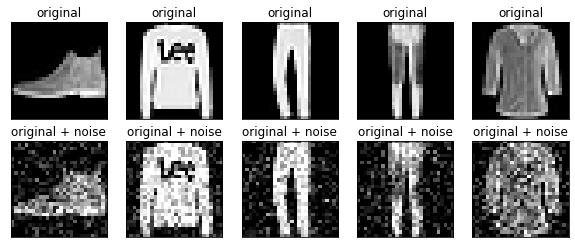

In [5]:
n = 5
plt.figure(figsize=(2*n, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_test_noisy[i])
    plt.title("original + noise")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Of course, you can increase or decrease the noise by simply changing the `noise` parameter.

Let's now create an autoencoder. This will use convolutional layers - but don't worry, you don't need to know in detail what they do, we will get back to them in the next class.

Start by creating an `encoder`, as before. However, instead of flattening the input and then using one `Dense` layer, we now use three different layers:
1. a `Reshape` layer, with `tf.keras.layers.Reshape((28,28,1), input_shape=(28,28))` (this is because convolutional layers work with 3 dimensions, so we convert our matrices into 3-dimensional arrays, where the last dimension simply has size 1 - so basically still a matrix)
1. a `Conv2D` layer, with `tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)`
1. a `Conv2D` layer, with `tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)`

In [6]:
encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape((28,28,1), input_shape=(28,28)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)]) 

Next, create a `decoder`. Again, this is simply a `Sequential` model, that basically builds a symmetric version of the `encoder`. This time, we need three layers:
1. a `Conv2DTranspose` layer (basically inverting a convolutional layer), with `tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')`
1. another `Conv2DTranspose` layer, with `tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')`
1. a `Conv2D` layer, that allows use to recreate the output, with `tf.keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')`

In [9]:
decoder = tf.keras.Sequential([
    tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

Do you see why the output is able to recreate the input? What is the critical ingredient here?

We can now combine everything into an `autoencoder`, exactly as we did before:

In [10]:
autoencoder = tf.keras.Sequential([encoder,decoder])

Next, take a look at the summary of the `encoder`:

In [11]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


Compare the dimensions of the original input with the dimension of the encoding: 

In [12]:
28*28*1

784

In [13]:
7*7*8

392

Let's also take a look at the decoding process:

In [14]:
decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 8)        584       
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


Next, compile the `autoencoder`. As before, we use the `MeanSquaredError` as a loss:

In [15]:
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

Finally, we need to train our `autoencoder`. Remember that we are taking the noisy image and then trying to predict the original one (**not** the noisy one) - so make sure to set the right "y" values for both training and validation.

Then, run the training for 10 epochs - this might take a bit, so it's a good time for a break.

In [16]:
autoencoder.fit(x=X_train_noisy, y=X_train_noisy,
                epochs=10,
                validation_data=(X_valid_noisy,X_valid_noisy))

Epoch 1/10
1563/1563 [==============================] - 46s 29ms/step - loss: 0.0295 - val_loss: 0.0206
Epoch 2/10
1563/1563 [==============================] - 44s 28ms/step - loss: 0.0169 - val_loss: 0.0151
Epoch 3/10
1563/1563 [==============================] - 44s 28ms/step - loss: 0.0144 - val_loss: 0.0139
Epoch 4/10
1563/1563 [==============================] - 45s 29ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 5/10
1563/1563 [==============================] - 46s 30ms/step - loss: 0.0134 - val_loss: 0.0133
Epoch 6/10
1563/1563 [==============================] - 43s 28ms/step - loss: 0.0133 - val_loss: 0.0132
Epoch 7/10
1563/1563 [==============================] - 43s 28ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 8/10
1563/1563 [==============================] - 45s 29ms/step - loss: 0.0131 - val_loss: 0.0130
Epoch 9/10
1563/1563 [==============================] - 44s 28ms/step - loss: 0.0130 - val_loss: 0.0130
Epoch 10/10
1563/1563 [==============================] - 43s 28m

Let's create again the encodings of the (noisy) test images, as well as the decoded version:

In [17]:
encoded_imgs = encoder(X_test_noisy).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()
print(X_test_noisy.shape)
print(encoded_imgs.shape)
print(decoded_imgs.shape)

(10000, 28, 28)
(10000, 7, 7, 8)
(10000, 28, 28, 1)


We can plot all three: original images, noisy versions, and decoded original images:

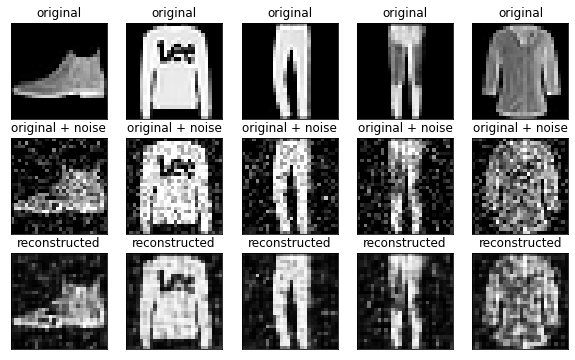

In [18]:
n = 5
plt.figure(figsize=(2*n,6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(X_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original + noise
    bx = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_test_noisy[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    # display reconstruction
    cx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    cx.get_xaxis().set_visible(False)
    cx.get_yaxis().set_visible(False)
plt.show()

Not at the level of an action thriller yet, but pretty good for a very basic neural network without much tuning!